In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import logging
import os

import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


# Set background and fontsize
rc_params = {
    'pdf.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'ps.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'axes.labelcolor': '#222222',
    'axes.labelsize': 8,
    'text.color': '#222222',
    'font.sans-serif' : 'Times New Roman',
    'text.usetex': False,
    'figure.figsize': (7.2, 4.45),
    'xtick.major.size': 0.00,
    'ytick.major.size': 0.00,
    'axes.labelpad': 0.1,
    }
sns.set(style='white', context='paper', rc=rc_params,
        font_scale=1.0)

# Enable logging
logging.basicConfig(level=logging.INFO)

In [3]:
from src.parameters import ANIMALS, SAMPLING_FREQUENCY, USE_LIKELIHOODS, BRAIN_AREAS

epoch_key = ('bon', 3, 2)

In [4]:
import itertools
from src.load_data import load_data

speed_metric='linear_speed'

data_types = set(['sorted_spikes', 'ad_hoc_ripple'])
data = load_data(epoch_key)

INFO:src.load_data:Loading data...
INFO:src.load_data:Finding multiunit high synchrony events...
INFO:src.load_data:Finding ripple times...
INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.02,
           detrend_type='constant', start_time=3729.0257, n_tapers=1)
INFO:src.load_data:Estimating gamma power...
INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=1,
           time_window_duration=0.1, time_window_step=0.1,
           detrend_type='constant', start_time=3729.0257, n_tapers=1)


In [5]:
from replay_identification import ReplayDetector

speed_metric = 'speed'
position_metric = 'linear_position2'

replay_detector = ReplayDetector(movement_state_transition_type='w_track_1D_random_walk')
replay_detector.fit(
    is_ripple=data['is_ripple'], speed=data['position_info'][speed_metric],
    position=data['position_info'][position_metric], spikes=data['spikes'],
    track_labels=data['position_info'].arm_name.values)

INFO:replay_identification.decoders:Fitting speed model...
INFO:replay_identification.decoders:Fitting spiking model...


INFO:replay_identification.decoders:Fitting replay movement state transition...


INFO:replay_identification.decoders:Fitting replay state transition...


ReplayDetector(infer_track_interior=True,
               lfp_model=<class 'sklearn.mixture.bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_type='w_track_1D_random_walk',
               movement_var=4.0,
               multiunit_density_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               multiunit_mo...: array([24., 24., 24., 24.,  6.])},
               multiunit_occupancy_kwargs={'bandwidth': array([6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.0, position_range=None, replay_speed=1,
               replay_state_transition_penalty=1e-05, speed_knots=None,
               speed_threshold=4.0, spike_model_knot_spacing=5,
               spike_model_penalty=0.5)

In [6]:
detector_results = replay_detector.predict(
    speed=data['position_info'][speed_metric],
    position=data['position_info'][position_metric],
    lfp_power=data['ripple_power'],
    spikes=data['spikes'],
    time=data['position_info'].index,
    use_likelihoods=['spikes'],
    use_smoother=True)

INFO:replay_identification.decoders:Predicting spikes likelihood...


INFO:replay_identification.decoders:Finding causal replay probability and position...
INFO:replay_identification.decoders:Finding acausal replay probability and position...


In [294]:
def plot_replay_with_data(replay_number, data, replay_info, epoch_key=None,
                          replay_detector=None,
                          spikes_detector_results=None,
                          lfp_power_detector_results=None,
                          multiunit_detector_results=None,
                          sampling_frequency=1500,
                          offset=pd.Timedelta(0.250, 's'),
                          position_metric='linear_distance',
                          speed_metric='linear_speed',
                          is_relative_time=False,
                          show_data_types=None, show_result_types=None):
    start_time = replay_info.loc[replay_number].start_time - offset
    end_time = replay_info.loc[replay_number].end_time + offset
    position_info = data['position_info'].loc[start_time:end_time]
    time = position_info.index.total_seconds()
    spike_results = (spikes_detector_results
                 .sel(time=slice(start_time, end_time))
                 .assign_coords(
                     time=lambda ds: ds.time / np.timedelta64(1, 's')))
    fig, axes = plt.subplots(3, 1, figsize=(ONE_COLUMN, ONE_COLUMN),
                             constrained_layout=True, sharex=True,
                             gridspec_kw={'height_ratios': [1, 2, 2]})
    plt.ticklabel_format(useOffset=False)
    cbar_kwargs = {
        'ticks': [0, 0.1],
        'orientation': 'vertical',
    }

    spike_kwargs = {
        'zorder': 0,
        'marker': '|',
        's': 20, 
        'linewidth': 1,
    }
    
    # Plot 1
    spike_results.replay_probability.plot(
        x='time', label='Non-Local', ax=axes[0], linewidth=2,
        color='#e377c2')
    (1 - spike_results.replay_probability).plot(
        x='time', label='Local', ax=axes[0], linewidth=2,
        color='#9467bd')
    axes[0].set_yticks([0, 1])
    axes[0].set_title('')
    axes[0].set_ylabel('Probability')
    axes[0].tick_params(length=0)
    axes[0].set_xlabel('')
#     axes[0].legend(loc='upper right',
#                    frameon=False, bbox_to_anchor=(1.4, 1.0),
#                    handlelength=1)
    axes[0].text(4434.4, 0.70, 'Local', color='#9467bd')
    axes[0].text(4434.65, 0.70, 'Non-Local', color='#e377c2')

    # Plot 2
    min_df = (data['position_info']
          .groupby('arm_name')[position_metric].min())
    max_df = (data['position_info']
              .groupby('arm_name')[position_metric].max())
    is_between_arms = ((spike_results.position > max_df['Center Arm']) & (spike_results.position < min_df['Right Arm']) |
                       (spike_results.position > max_df['Right Arm']) & (spike_results.position < min_df['Left Arm']))
    spike_results.acausal_posterior.rename('Posterior').sum('state').where(~is_between_arms, np.nan).plot(x='time', y='position',
                                         vmin=0.0, vmax=0.1, ax=axes[1], rasterized=True, cbar_kwargs=cbar_kwargs)
    axes[1].set_ylabel('Position [cm]')
    axes[1].set_yticks([0, np.ceil(spike_results.position.values.max())])
#     axes[1].plot(position_info.index.total_seconds(),
#                  position_info[position_metric].values,
#                  linewidth=3, linestyle='--', color='white')
    axes[1].set_title('')
    
    min_time = np.asarray(spike_results.time.min())
    for arm_name, max_position in max_df.iteritems():
        axes[1].text(min_time, max_position - 5, arm_name, color='white',
                     verticalalignment='top', fontsize=8)
    axes[1].tick_params(length=0)
    axes[1].set_xlabel('')
    
    # Plot 3
    place_bin_centers = replay_detector.place_bin_centers_.squeeze(axis=-1)
    place_bin_edges = replay_detector.place_bin_edges_.squeeze(axis=-1)
    is_track = (np.histogram(data['position_info'][position_metric],
                             bins=place_bin_edges)[0] > 0)
    place_fields = (replay_detector
                    ._spiking_likelihood
                    .keywords['place_conditional_intensity'].T
                    * sampling_frequency)
    place_fields[:, ~is_track] = 0.0

    spikes = data['spikes'].loc[start_time:end_time]
    plot_replay_spiking_ordered_by_place_fields(
        spikes.values, place_fields, place_bin_centers, ax=axes[2],
        time=time, s=20)
    axes[2].set_yticks([])
    axes[2].set_yticklabels([], [])
    axes[2].tick_params(length=0)
    axes[2].set_xlabel('')
    
    axes[2].set_xlim((time.min(), time.max()))
    axes[2].set_xlabel('Time [s]')
    sns.despine()

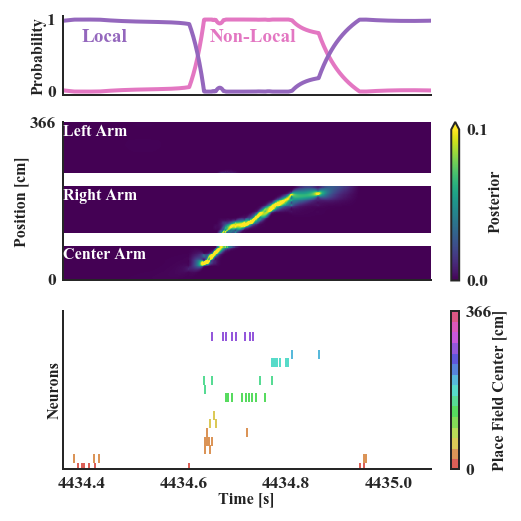

In [295]:
import pandas as pd

replay_info = data['ripple_times'].copy()
replay_number = 189

plot_replay_with_data(replay_number, data, replay_info, epoch_key=None,
                          replay_detector=replay_detector,
                          spikes_detector_results=detector_results,
                          lfp_power_detector_results=None,
                          multiunit_detector_results=None,
                          sampling_frequency=1500,
                          offset=pd.Timedelta(0.250, 's'),
                          position_metric=position_metric,
                          speed_metric=speed_metric,
                          is_relative_time=False,
                          show_data_types=['spikes'], show_result_types=['spikes']);

fig_dir = '/Users/edeno/Documents/GitHub/Characterizing-hippocampal-replay-using-hybrid-point-process-state-space-models/'
plt.savefig(fig_dir + 'fig2.pdf',
            transparent=True, dpi=300, bbox_inches='tight')

In [ ]:
is_replay = data['is_ripple'].values
